## Human Pose Estimation

In [ ]:
# clone the human-pose-estimation.pytorch repo
!git clone https://github.com/microsoft/human-pose-estimation.pytorch.git

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 68.78 KiB | 370.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
# Copy only the required files
!cp human-pose-estimation.pytorch/lib/core/config.py .
!cp human-pose-estimation.pytorch/lib/models/pose_resnet.py .
!cp human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml .
 

In [ ]:
import torch
import torchvision
from torchvision import transforms

from PIL import Image,ImageDraw
import matplotlib.pyplot as plt

import numpy as np
from google.colab.patches import cv2_imshow

import cv2


In [ ]:
from config import config
from config import update_config


In [ ]:
# Update configuration as required
update_config('256x256_d256x3_adam_lr1e-3.yaml')

In [ ]:
import pose_resnet
model = pose_resnet.get_pose_net(config, is_train=False)

In [ ]:
from torchsummary import summary
summary(model,(3,256,256))

In [ ]:
# Download model trained on mpii dataset with resnet 50 base
!gdown https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc

Downloading...
From: https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc
To: /content/pose_resnet_50_256x256.pth.tar
136MB [00:02, 56.3MB/s]


In [ ]:
model.load_state_dict(torch.load('pose_resnet_50_256x256.pth.tar',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
!wget http://bp.funrahi.com/2013/08/kidzania-launch-shahrukh-khan/kidzania-launch-shahrukh-khan-61755.jpg -O shahrukh.jpg

--2020-09-01 15:35:06--  http://bp.funrahi.com/2013/08/kidzania-launch-shahrukh-khan/kidzania-launch-shahrukh-khan-61755.jpg
Resolving bp.funrahi.com (bp.funrahi.com)... 172.67.179.45, 104.28.2.180, 104.28.3.180, ...
Connecting to bp.funrahi.com (bp.funrahi.com)|172.67.179.45|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bp.funrahi.com/file/frcontent/2013/08/kidzania-launch-shahrukh-khan/kidzania-launch-shahrukh-khan-61755.jpg [following]
--2020-09-01 15:35:06--  https://bp.funrahi.com/file/frcontent/2013/08/kidzania-launch-shahrukh-khan/kidzania-launch-shahrukh-khan-61755.jpg
Connecting to bp.funrahi.com (bp.funrahi.com)|172.67.179.45|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 833192 (814K) [image/jpeg]
Saving to: ‘shahrukh.jpg’

shahrukh.jpg        100%[===================>] 813.66K   473KB/s    in 1.7s    

2020-09-01 15:35:10 (473 KB/s) - ‘shahrukh.jpg’ saved [833192/833192]



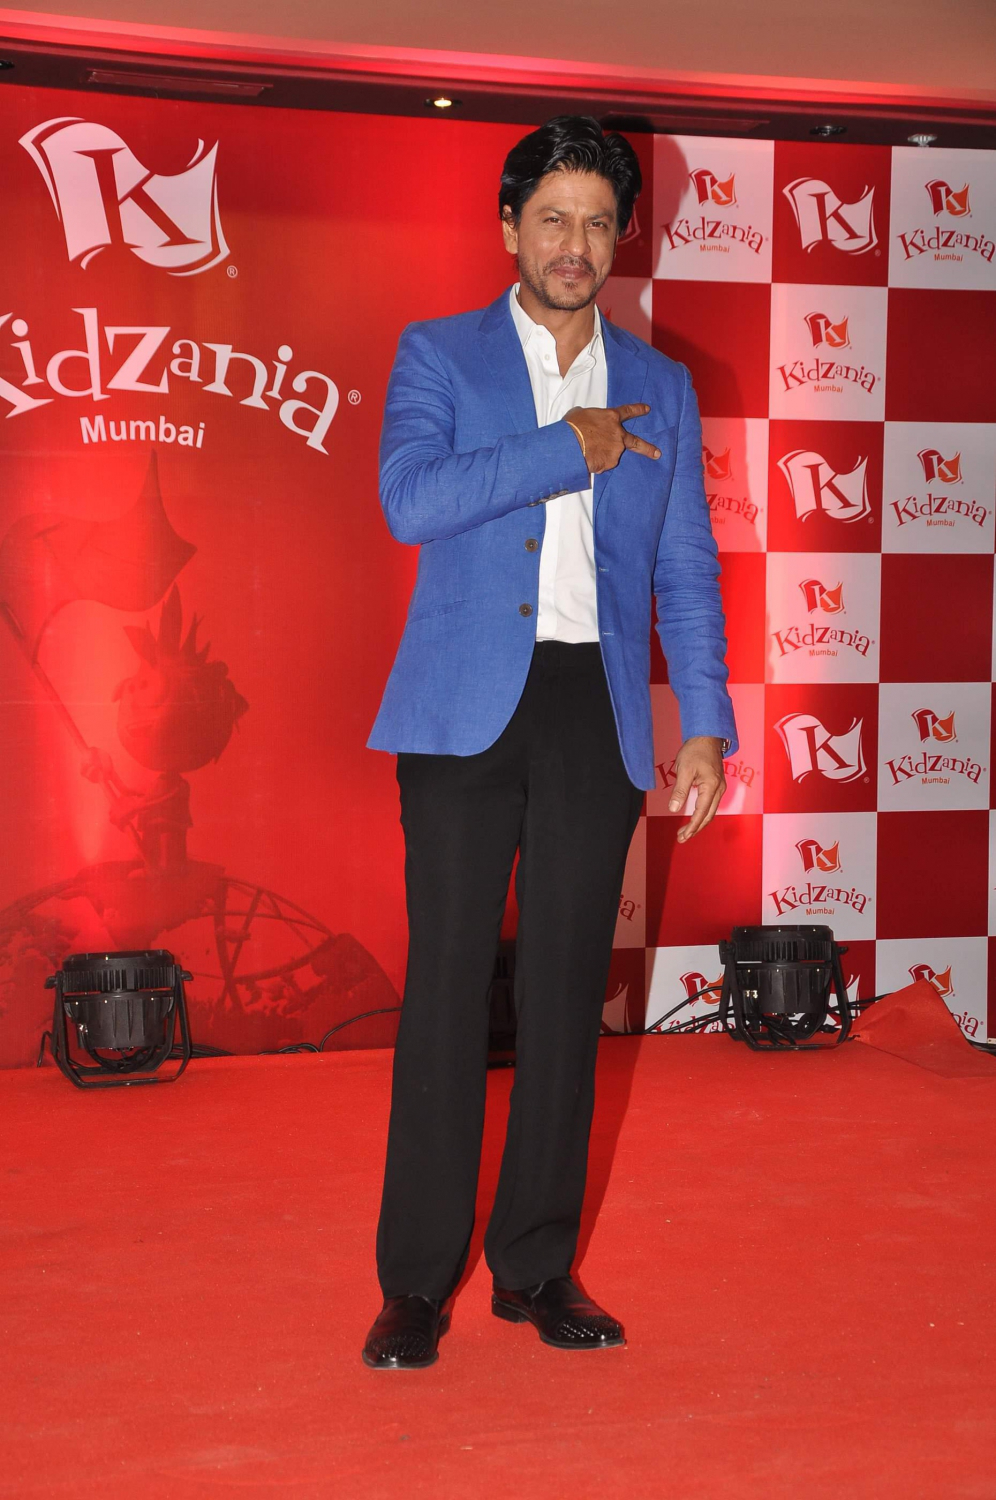

In [ ]:
# Open image as PIL instance
in_img = Image.open('shahrukh.jpg')
in_img

In [ ]:
# Define image_transform. Model is expecting 256x256 tensor as image
image_transform = transforms.Compose([
                              transforms.Resize((256,256)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [ ]:
# Get predictions by by paasing image to model through image_transform
model.eval()  # indicate Model evaluation mode
predictions = model(image_transform(in_img).unsqueeze(0))
# Reduce extra 0th dimension
predictions = predictions.squeeze(0)

In [ ]:
# get a numpy copy of the prediction tensor
import copy
predictions = copy.deepcopy(predictions.cpu().detach().numpy())

In [ ]:
print(predictions)

In [ ]:
# Get number of joints, predicted height and widths
num_joints,pred_height,pred_width = predictions.shape

In [ ]:
# Define joint names
joint_dict = {0:"r_ankle",1:"r_knee", 2: "r_hip",
              3: "l_hip", 4:"l_knee", 5: "l ankle",
              6: "pelvis",7: "thorax",8: "upper_neck",
              9: "head_top",10: "r_wrist", 11:"r_elbow", 
              12: "r_shoulder", 13:"l_shoulder", 
              14:"l_elbow", 15: "l_wrist"}

In [ ]:
# Define joint pairs. This will be used later for plotting the pose over image
joint_pairs = [
# TORSO
              [9, 8],   # head_top <-> upper_neck
              [8, 7],   # upper_neck <-> thorax
              [7, 6],   # thorax <-> pelvis
# RIGHT ARM  
              [7, 12],  # thorax <-> r_shoulder
              [12, 11], # r_shoulder <-> r_elbow
              [11, 10], # r_elbow <-> r_wrist
# LEFT ARM
              [7, 13],  # thorax <-> l_shoulder
              [13, 14], # l_shoulder <-> l_elbow
              [14, 15], # l_elbow <-> l_wrist             
# RIGHT LEG
              [6, 2], # pelvis <-> r_hip
              [2, 1], # r_hip <-> r_knee
              [1, 0], # r_knee <-> r_ankle
# LEFT LEG
              [6, 3], # pelvis <-> l_hip
              [3, 4], # l_hip <-> l_knee
              [4, 5] # l_knee <-> l_ankle
]

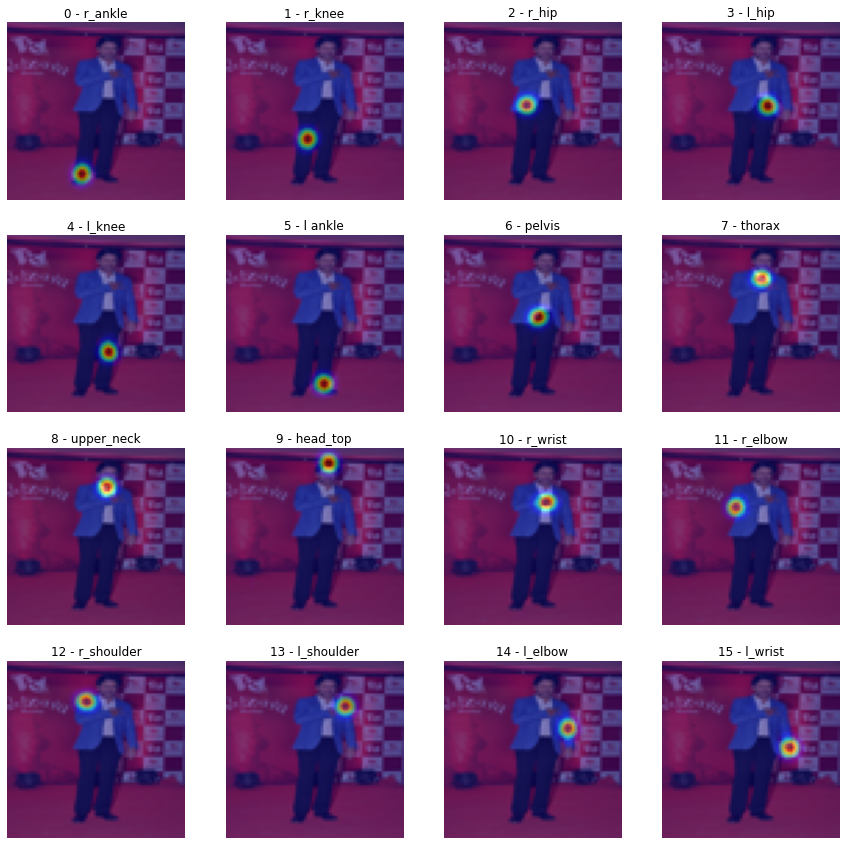

In [ ]:
# Plot joint heatmaps over the input image
plt.figure(figsize=(15, 15))
for i in range(num_joints):
    plt.subplot(4, 4, i + 1)
    plt.title(f'{i} - {joint_dict[i]}')
    plt.imshow(in_img.resize((pred_width, pred_height)))
    plt.imshow(predictions[i], alpha=0.5, cmap='jet')
    plt.axis('off')
plt.show()
  

In [ ]:
# Find keypoint coordinates
joint_coords = [cv2.minMaxLoc(x)[3] for x in predictions]

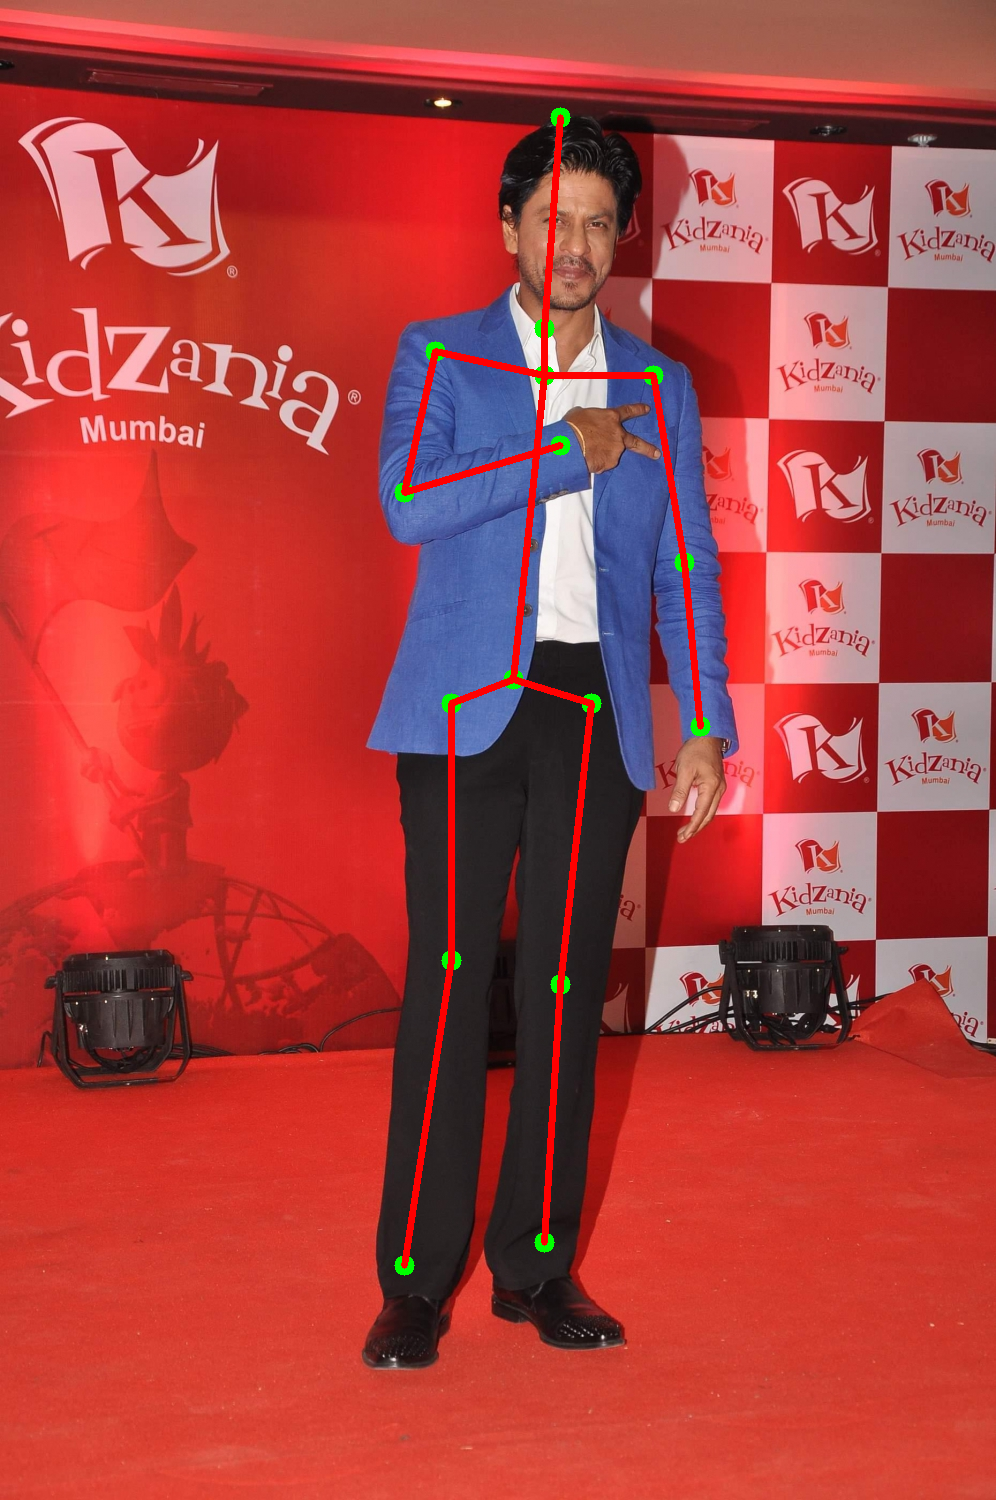

In [ ]:
# Create stick figure
stick_img = cv2.imread('shahrukh.jpg')
img_height,img_width, _ = stick_img.shape

# Scale joint keypoints according to input image size
new_joint_coords = [(j[0]*img_width//pred_width,j[1]*img_height//pred_height) for j in joint_coords]

# Plot circles at points corresponding to the keypoints
for joint in new_joint_coords:
  stick_img = cv2.circle(stick_img,joint,radius=10,color=(0,255,0),thickness = -1)

# Draw lines connecting the joint pairs
for pair in joint_pairs:
  stick_img = cv2.line(stick_img, new_joint_coords[pair[0]], new_joint_coords[pair[1]], color = (0,0,255), thickness = 5) 

cv2_imshow(stick_img)

In [ ]:
torch.save(model.state_dict(), "model_save.pt")

In [ ]:
import os

In [ ]:
print('Size (MB):', os.path.getsize("model_save.pt")/1e6)

Size (MB): 136.326105
